A Look Into The Top 100 Songs on Billboard (Week of Augest 4th, 2025)

In [61]:
import pandas as pd 
import numpy as np

data = pd.read_csv('../billboard_hot_100_with_lyrics.csv')
data.dtypes

title              object
artist             object
lyrics             object
rank                int64
last_week           int64
peak_rank           int64
weeks_on_chart      int64
release_year      float64
lyric_length        int64
dtype: object

In [62]:
data.head()

,title,artist,lyrics,rank,last_week,peak_rank,weeks_on_chart,release_year,lyric_length
0,Ordinary,Alex Warren,44 ContributorsTranslationsItalianoEspañolУкра...,1,1,1,25,2025.0,356
1,Golden,"HUNTR/X: EJAE, Audrey Nuna & REI AMI",53 ContributorsTranslationsRomanizationEnglish...,2,2,2,6,2025.0,345
2,What I Want,Morgan Wallen Featuring Tate McRae,22 ContributorsTranslationsFrançaisItalianoNed...,3,4,1,11,2025.0,433
3,Daisies,Justin Bieber,44 ContributorsTranslationsČeskyItalianoPolski...,4,3,2,3,2025.0,341
4,Just In Case,Morgan Wallen,17 ContributorsTranslationsEspañolJust In Case...,5,5,2,19,2025.0,391


Data Cleaning

In [63]:
import re

def clean_lyrics(lyrics):
    
    if pd.isna(lyrics) or lyrics == '':
        return None
    
    # Convert lyrics to string type (allows for slicing but intuitively makes sense for lyrics)
    lyrics = str(lyrics)
    
    # Regex expression gets everything before and including the first 'lyrics' (used to remove the first line)
    lyrics_match = re.search(r'.*?lyrics\s*', lyrics, re.IGNORECASE)
    if lyrics_match:
        lyrics = lyrics[lyrics_match.end():]
        
    # Same as above but include | (bitwise OR) re.DOTALL (to match across multiple lines)    
    read_more_match = re.search(r'.*?read more\s*', lyrics, re.IGNORECASE | re.DOTALL)
    if read_more_match:
        lyrics = lyrics[read_more_match.end():]
        
        
    lyrics = re.sub(r'[""]', '"', lyrics)  # Normalize quotes
    lyrics = re.sub(r'\s+', ' ', lyrics)   # Multiple spaces → single space

    lyrics = lyrics.strip()
    
    return lyrics

print(f"First 200 characters of the first song: \n{data['lyrics'][0][0:200]}\n")

data['lyrics'] = data['lyrics'].apply(clean_lyrics)

print(f"First full song: \n{data['lyrics'][0]}")

First 200 characters of the first song: 
44 ContributorsTranslationsItalianoEspañolУкраїнськаDeutschРусский (Russian)PortuguêsČeskyOrdinary Lyrics
They say, "The holy water's watered down
And this town's lost its faith
Our colors will fade e

First full song: 
They say, "The holy water's watered down And this town's lost its faith Our colors will fade eventually" So, if our time is runnin' out Day after day We'll make the mundane our masterpiece Oh, my, my Oh, my, my love I take one look at you You're takin' me out of the ordinary I want you layin' me down 'til we're dead and buried On the edge of your knife, stayin' drunk on your vine The angels up in the clouds are jealous knowin' we found Somethin' so out of the ordinary You got me kissin' thе ground of your sanctuary Shatter me with your touch, oh, Lord, return mе to dust The angels up in the clouds are jealous knowin' we found Hopeless hallelujah On this side of Heaven's gate Oh, my life, how do ya Breathe and take my breath away?

In [64]:
# Identify songs that will be removed
songs_to_remove = data[data['lyrics'].isna()]
print(f"Songs that will be removed (no lyrics after cleaning):")
if len(songs_to_remove) > 0:
    for index, song in songs_to_remove.iterrows():
        print(f" - '{song['title']}' by {song['artist']} (Rank #{song['rank']})")

# Remove songs without lyrics
print(f"\nSongs before removing null lyrics: {len(data)}")
data = data.dropna(subset=['lyrics'])
print(f"Songs after removing null lyrics: {len(data)}")

Songs that will be removed (no lyrics after cleaning):
 - 'Takedown' by JEONGYEON, JIHYO & CHAEYOUNG Of TWICE (Rank #67)

Songs before removing null lyrics: 100
Songs after removing null lyrics: 99


In [65]:
# Convert title, artist, and lyrics to string (though lyrics should already be string after our cleaning)
data['title'] = data['title'].astype('string')
data['artist'] = data['artist'].astype('string')
data['lyrics'] = data['lyrics'].astype('string')

data['release_year'] = data['release_year'].astype('int64')

# Add a new column for word count
data['word_count'] = data['lyrics'].apply(lambda x: len(x.split()))

data.dtypes

title             string[python]
artist            string[python]
lyrics            string[python]
rank                       int64
last_week                  int64
peak_rank                  int64
weeks_on_chart             int64
release_year               int64
lyric_length               int64
word_count                 int64
dtype: object

In [66]:
data.isna().sum()

title             0
artist            0
lyrics            0
rank              0
last_week         0
peak_rank         0
weeks_on_chart    0
release_year      0
lyric_length      0
word_count        0
dtype: int64

In [67]:
data.to_csv('../billboard_hot_100_cleaned.csv', index=False)

Sentiment

In [68]:
from transformers import pipeline

# Initialize the emotion classifier pipeline with a pretrained model
emotion_classifier = pipeline(
    "text-classification", 
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True,
    device=-1
)

print(emotion_classifier("I love programming!")) #testing

Device set to use cpu
c:\Users\danny\Coding Outside\Projects\LyricPopularity\.venv312\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'anger', 'score': 0.0026277850847691298}, {'label': 'disgust', 'score': 0.0007785824709571898}, {'label': 'fear', 'score': 0.0003582449571695179}, {'label': 'joy', 'score': 0.9866405129432678}, {'label': 'neutral', 'score': 0.0027272517327219248}, {'label': 'sadness', 'score': 0.003636218374595046}, {'label': 'surprise', 'score': 0.0032313845586031675}]]


In [69]:
def classify_emotions(lyrics):
    
    try:
        
        chunks = [lyrics[i:i+512] for i in range(0, len(lyrics), 512)]
        
        all_emotions_scores = []
        chunk_lengths = []
                    
        emotion_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

        for chunk in chunks:
            emotions = emotion_classifier(
                lyrics,
                truncation=True,
                max_length=512
            )[0] # Utilize the pipeline to classify emotions
            emotions_dict = {emotion['label']: emotion['score'] for emotion in emotions} # Create a dictionary from the list of emotions
            
            # If there are missing emotions, they are assigned a score of 0.0
            for emotion in emotion_names:
                if emotion not in emotions_dict:
                    emotions_dict[emotion] = 0.0
            
            all_emotions_scores.append(emotions_dict)
            chunk_lengths.append(len(chunk))
            
        avg_emotions = {}
        for emotion in emotion_names:
            avg_emotions
            weighted_sum = 0.0
            for i in range(len(all_emotions_scores)):
                weighted_sum += all_emotions_scores[i][emotion] * chunk_lengths[i]
            avg_score = weighted_sum / sum(chunk_lengths)
            avg_emotions[emotion] = avg_score
                
        top_emotion = max(avg_emotions.items(), key=lambda x: x[1])
        
        result = {  
            'top_emotion': top_emotion[0],
            'top_emotion_score': top_emotion[1],
            **avg_emotions
        }
        
        return result
    
    except Exception as e:
        print(f"Error classifying emotions for lyrics: {e}")
        return {
            'top_emotion': None,
            'top_emotion_score': None,
            'anger': 0.0,
            'disgust': 0.0,
            'fear': 0.0,
            'joy': 0.0,
            'neutral': 0.0,
            'sadness': 0.0,
            'surprise': 0.0
        }

In [70]:
emotion_results = []

for index, lyrics in enumerate(data['lyrics']):
    if index % 10 == 0 or index == 99:
        print(f"Processing song {index + 1}/{len(data)}")
    emotions = classify_emotions(lyrics[:512])
    emotion_results.append(emotions)
    
emotions_data = pd.DataFrame(emotion_results)
emotions_data.head()
data = pd.concat([data.reset_index(drop=True), emotions_data.reset_index(drop=True)], axis=1)

Processing song 1/99
Processing song 11/99
Processing song 21/99
Processing song 31/99
Processing song 41/99
Processing song 51/99
Processing song 61/99
Processing song 71/99
Processing song 81/99
Processing song 91/99


In [71]:
data.head(5)

,title,artist,lyrics,rank,last_week,peak_rank,weeks_on_chart,release_year,lyric_length,word_count,top_emotion,top_emotion_score,anger,disgust,fear,joy,neutral,sadness,surprise
0,Ordinary,Alex Warren,"They say, ""The holy water's watered down And t...",1,1,1,25,2025,356,352,sadness,0.354639,0.079038,0.093723,0.091241,0.036207,0.134498,0.354639,0.210655
1,Golden,"HUNTR/X: EJAE, Audrey Nuna & REI AMI","I was a ghost, I was alone 어두워진 앞길속에 (Hah) Giv...",2,2,2,6,2025,345,304,fear,0.383440,0.063155,0.013784,0.383440,0.026303,0.099525,0.206061,0.207732
2,What I Want,Morgan Wallen Featuring Tate McRae,"She said, ""You don't want this heart, boy, it'...",3,4,1,11,2025,433,428,anger,0.451607,0.451607,0.059232,0.230261,0.021143,0.129680,0.091698,0.016379
3,Daisies,Justin Bieber,"Throwin' petals like, ""Do you love me or not?""...",4,3,2,3,2025,341,336,neutral,0.433261,0.324150,0.110138,0.069871,0.014375,0.433261,0.031724,0.016482
4,Just In Case,Morgan Wallen,I ain't sayin' that I always sleep alone I ain...,5,5,2,19,2025,391,386,sadness,0.442795,0.040187,0.021925,0.038544,0.044610,0.391176,0.442795,0.020762


In [72]:
data.to_csv('../billboard_hot_100_sentiment.csv', index=False)

EDA

In [73]:
df = pd.read_csv('../billboard_hot_100_sentiment.csv')

df[['rank', 'peak_rank', 'weeks_on_chart']].describe()


,rank,peak_rank,weeks_on_chart
count,99.000000,99.000000,99.000000
mean,50.333333,31.313131,15.929293
std,29.110977,25.292028,18.607247
min,1.000000,1.000000,1.000000
25%,25.500000,8.000000,4.000000
50%,50.000000,28.000000,11.000000
75%,75.500000,52.000000,18.500000
max,100.000000,87.000000,102.000000


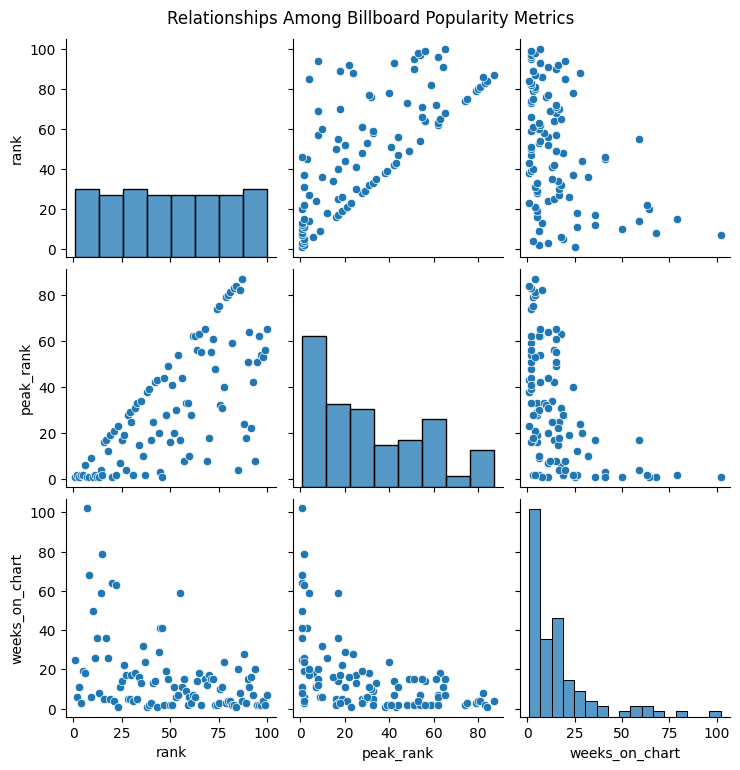

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.pairplot(df[['rank', 'peak_rank', 'weeks_on_chart']])
plt.suptitle('Relationships Among Billboard Popularity Metrics', y=1.02)
plt.show()


In [75]:
df[['word_count', 'lyric_length']].describe()


,word_count,lyric_length
count,99.000000,99.000000
mean,376.373737,391.515152
std,135.945786,139.478867
min,109.000000,150.000000
25%,301.500000,314.500000
50%,344.000000,350.000000
75%,415.000000,432.000000
max,843.000000,892.000000


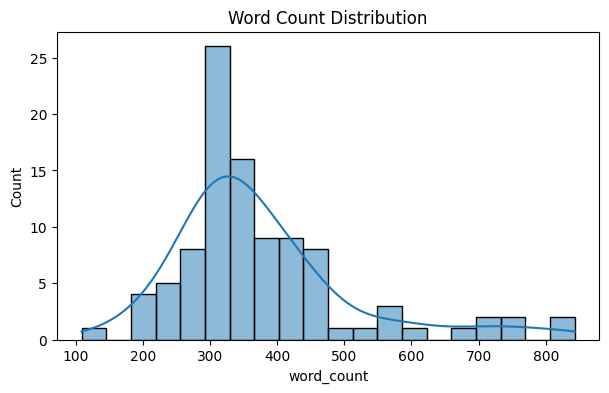

In [76]:
plt.figure(figsize=(7, 4))

sns.histplot(df['word_count'], bins=20, kde=True)
plt.title('Word Count Distribution')
plt.show()

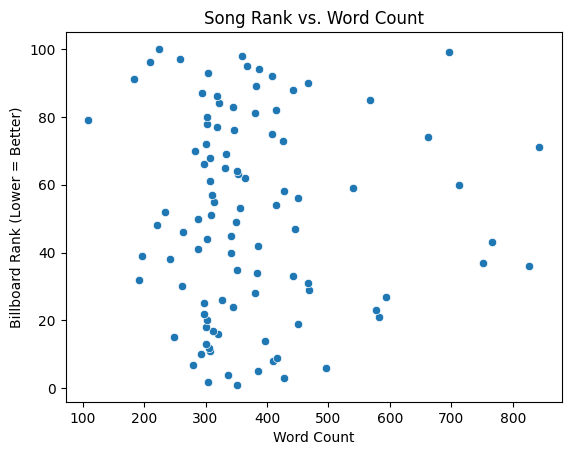

In [77]:
sns.scatterplot(x='word_count', y='rank', data=df)
plt.title('Song Rank vs. Word Count')
plt.xlabel('Word Count')
plt.ylabel('Billboard Rank (Lower = Better)')
plt.show()

In [78]:
df['top_emotion'].value_counts()

top_emotion
sadness     25
neutral     22
fear        20
anger       17
joy          7
disgust      4
surprise     4
Name: count, dtype: int64

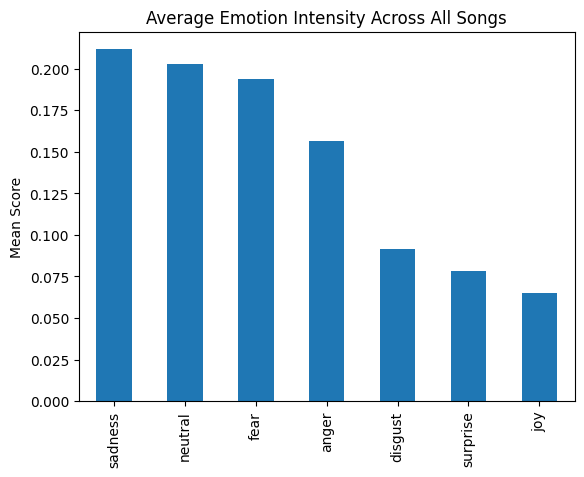

In [79]:
# Compare average emotion scores
emotion_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
avg_emotions = df[emotion_names].mean().sort_values(ascending=False)

avg_emotions.plot(kind='bar')
plt.title('Average Emotion Intensity Across All Songs')
plt.ylabel('Mean Score')
plt.show()

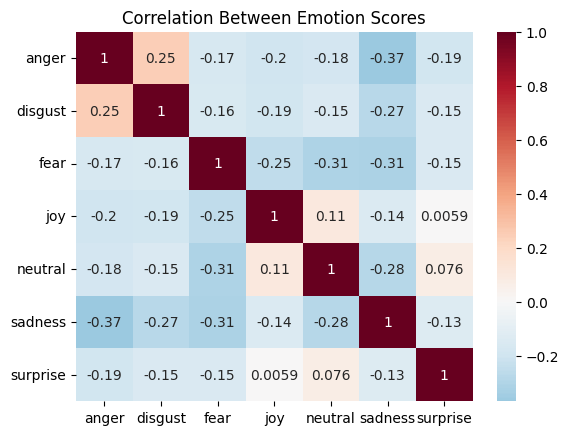

In [80]:
corr = df[emotion_names].corr()
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation Between Emotion Scores')
plt.show()


C:\Users\danny\AppData\Local\Temp\ipykernel_21488\1654082936.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emotion_by_rank = df.groupby('rank_group')[emotion_names].mean()


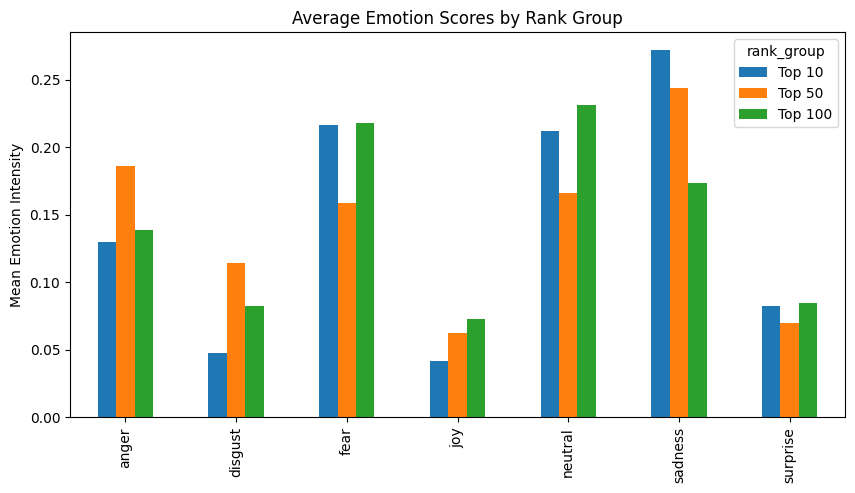

In [81]:
# Define rank groups
df['rank_group'] = pd.cut(df['rank'], bins=[0,10,50,100], labels=['Top 10','Top 50','Top 100'])

# Average emotion intensity per group
emotion_by_rank = df.groupby('rank_group')[emotion_names].mean()
emotion_by_rank.T.plot(kind='bar', figsize=(10,5))
plt.title('Average Emotion Scores by Rank Group')
plt.ylabel('Mean Emotion Intensity')
plt.show()


In [82]:
import re
import nltk
from nltk.corpus import stopwords
from better_profanity import profanity

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Clean stop words and profanity
def clean_stop_words(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))  # remove punctuation/numbers (anything not a letter or space)
    text = text.lower()
    words = [w for w in text.split() if w not in stop_words and not profanity.contains_profanity(w) and len(w) > 2]
    return words

df['important_words'] = df['lyrics'].apply(clean_stop_words)
df[['title', 'important_words']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,important_words
0,Ordinary,"[say, holy, waters, watered, towns, lost, fait..."
1,Golden,"[ghost, alone, hah, given, throne, didnt, know..."
2,What I Want,"[said, dont, want, heart, boy, already, broke,..."
3,Daisies,"[throwin, petals, like, love, head, spinnin, d..."
4,Just In Case,"[aint, sayin, always, sleep, alone, aint, sayi..."


In [83]:
# Get all words in all songs
all_words = [word for important_words in df['important_words'] for word in important_words]

# Convert to Series and use value_counts()
words_freq = pd.Series(all_words).value_counts().head(25)

# Convert to DataFrame
words_df = words_freq.reset_index()
words_df.columns = ['Word', 'Frequency']
words_df

,Word,Frequency
0,dont,311
1,like,279
2,yeah,255
3,know,217
4,get,197
5,baby,195
6,got,184
7,aint,176
8,party,169
9,youre,143


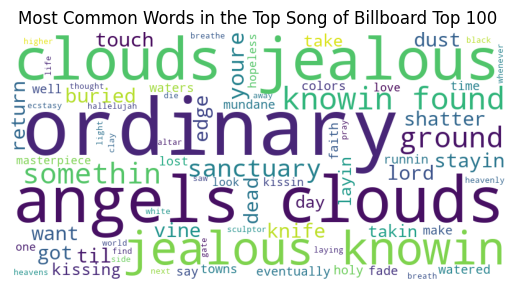

In [84]:
from wordcloud import WordCloud

number_1_song_words = ' '.join(df['important_words'][0])
wc2 = WordCloud(width=800, height=400, background_color='white').generate(number_1_song_words)

plt.imshow(wc2)
plt.axis('off') # removes x/y axes
plt.title('Most Common Words in the Top Song of Billboard Top 100')
plt.show()

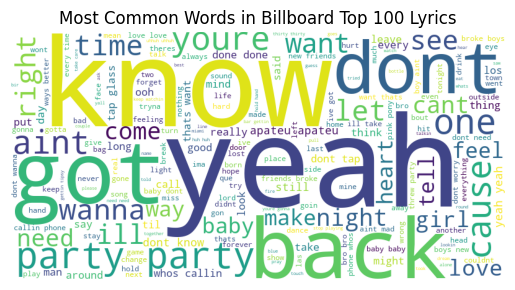

In [85]:
text = ' '.join(all_words)
wc = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.imshow(wc)
plt.axis('off') # removes x/y axes
plt.title('Most Common Words in Billboard Top 100 Lyrics')
plt.show()


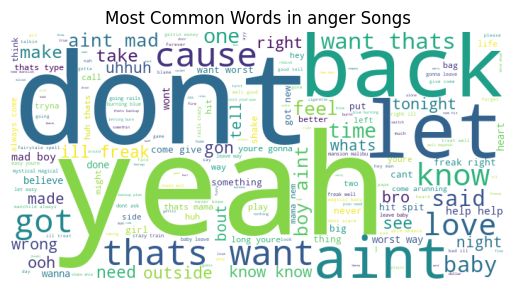

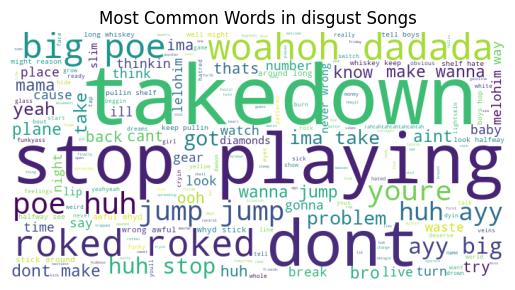

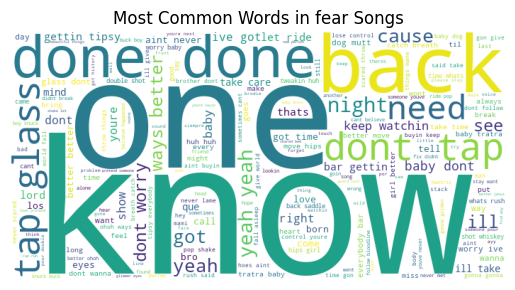

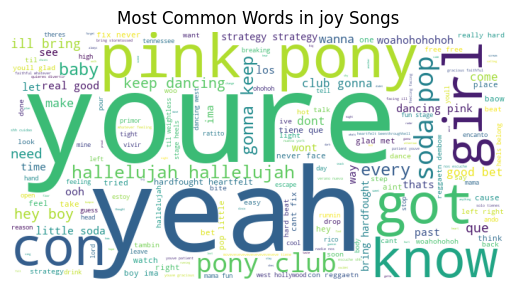

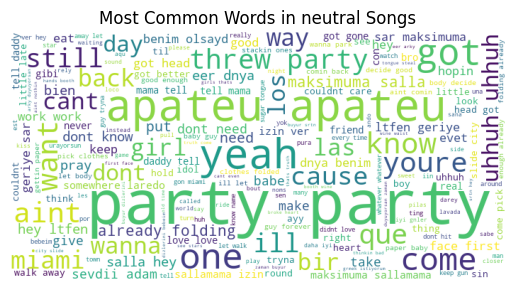

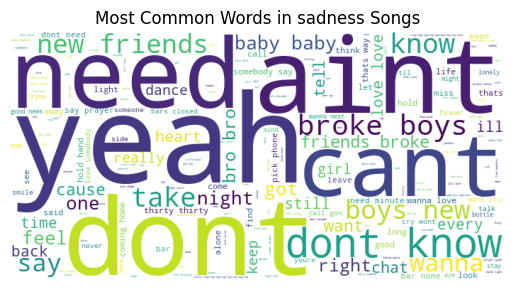

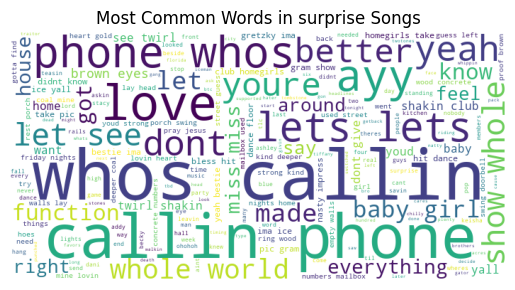

In [ ]:
for emotion in ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']:
    # Collect all words from songs with that emotion having the top sentiment score
    emotion_words = [' '.join(words) for words in df[df['top_emotion'] == emotion]['important_words']]

    text = ' '.join(emotion_words)
    wc3 = WordCloud(width=700, height=350, background_color='white').generate(text)

    plt.figure()
    plt.imshow(wc3)
    plt.axis('off')
    plt.title(f'Most Common Words in {emotion} Songs')
    plt.show()